# Preprocess HBEC IFN data

For now, isolate the Type I interferons

In [40]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'


In [42]:
%matplotlib inline

### Read the data

In [43]:
adata = sc.read(data_path + 'HBEC_condition_assigned_deep.h5ad')
adata = adata[adata.obs.condition != 'unassigned'].copy()

In [44]:
adata.obs['donor'] = adata.obs['condition'].apply(lambda x: x.split('_')[0])
adata.obs['stim'] = adata.obs['condition'].apply(lambda x: x.split('_')[1])
adata.obs['time'] = adata.obs['condition'].apply(lambda x: x.split('_')[2] if 'control' not in x else 0)

In [45]:
adata = adata[adata.obs['stim']=='control'].copy()

In [46]:
adata.shape

(3038, 36741)

In [47]:
# adata = adata[(adata.obs['stim'].isin(['control', 'alpha', 'beta']))]

### Slice out mRNA from ADT

In [48]:
adt_adata = adata[:, adata.var.query('feature_types == "Antibody Capture" & ~gene_ids.str.contains("hash").values').index].copy()
rna_adata = adata[:, adata.var.query('feature_types != "Antibody Capture"').index].copy()

In [49]:
rna_adata.shape

(3038, 36601)

In [50]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

control    1.0
Name: stim, dtype: float64

### Process RNA data

In [51]:
rna_adata.obs.head(5)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time
AAACGAAGTACACGTT-1,518,donor0,SNG,0,hash-1,d2513_control,d2513,control,0
AAACGCTGTACCGTCG-1,1744,donor0,SNG,0,hash-1,d2513_control,d2513,control,0
AACAAAGTCACCTACC-1,1269,donor0,SNG,0,hash-1,d2513_control,d2513,control,0
AACAGGGCATCGGTTA-1,798,donor0,SNG,0,hash-1,d2513_control,d2513,control,0
AACCAACGTCCCTGTT-1,785,donor0,SNG,0,hash-1,d2513_control,d2513,control,0


In [52]:
sc.pp.filter_cells(rna_adata, min_genes=50)
# sc.pp.filter_genes(rna_adata, min_cells=500)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [53]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [54]:
# rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 2500, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [55]:
rna_adata.shape

(2360, 36601)

In [56]:
rna_adata.obs.stim.value_counts()/rna_adata.shape[0]

control    1.0
Name: stim, dtype: float64

In [57]:
rna_adata_counts = rna_adata.copy()

In [58]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [59]:
sc.pp.log1p(rna_adata)

In [60]:
rna_adata.raw = rna_adata

In [61]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.01, max_mean=3, min_disp=0.5, batch_key='donor')

... storing 'donor' as categorical
... storing 'stim' as categorical
... storing 'time' as categorical


In [62]:
rna_adata = rna_adata[:, rna_adata.var.highly_variable & ~rna_adata.var.mt]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [63]:
rna_adata.raw.shape

(2360, 36601)

In [66]:
sc.pp.regress_out(rna_adata, ['total_counts', 'pct_counts_mt'])

In [67]:
# sc.pp.combat(rna_adata, key='donor')

In [68]:
sc.pp.scale(rna_adata, max_value=10)

In [69]:
sc.tl.pca(rna_adata, svd_solver='arpack')

In [70]:
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=40)


In [71]:
sc.tl.umap(rna_adata)

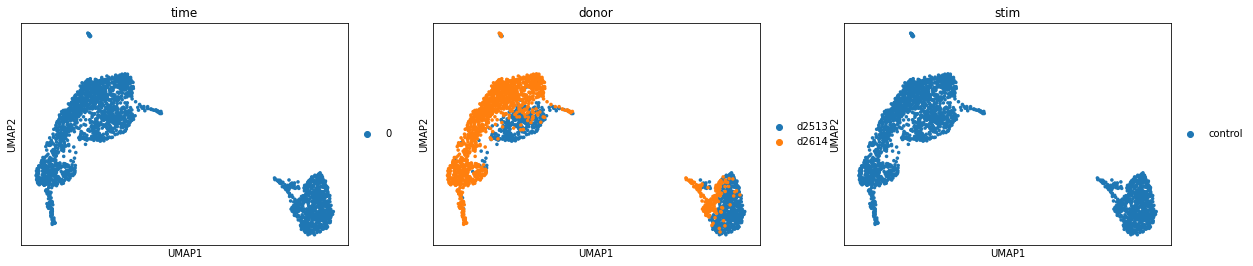

In [72]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim'])

### Clustering

In [73]:
sc.tl.leiden(rna_adata, resolution=1.5)

In [74]:
rna_adata.obs.head(5)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACGCTGTACCGTCG-1,1744,donor0,SNG,0,hash-1,d2513_control,d2513,control,0,4441,4441,13917.0,721.0,5.180714,4
AACAAAGTCACCTACC-1,1269,donor0,SNG,0,hash-1,d2513_control,d2513,control,0,3737,3737,8837.0,700.0,7.921240,0
AACAGGGCATCGGTTA-1,798,donor0,SNG,0,hash-1,d2513_control,d2513,control,0,2401,2401,7045.0,402.0,5.706175,7
AACCAACGTCCCTGTT-1,785,donor0,SNG,0,hash-1,d2513_control,d2513,control,0,2483,2483,8044.0,637.0,7.918946,7
AACCACAGTATGTCCA-1,864,donor0,SNG,0,hash-1,d2513_control,d2513,control,0,2823,2823,5408.0,649.0,12.000740,4


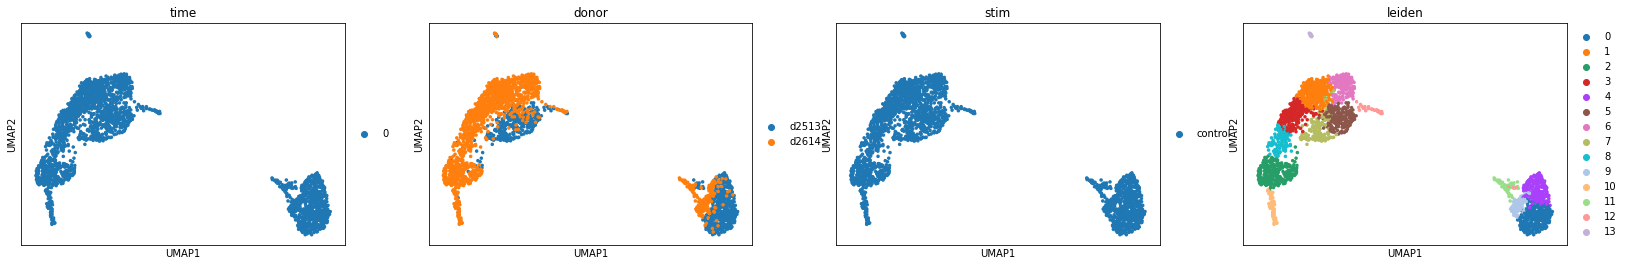

In [75]:
sc.pl.umap(rna_adata, color=['time', 'donor', 'stim', 'leiden'], s=50)

### Identify cell types using marker genes

In [76]:
import pandas as pd

In [77]:
marker_genes = ['KRT5', 'DAPL1', 'TP63', 'KRT4', 'KRT13', 'SCGB1A1','KRT15', 'LYPD2','FOXJ1', 'CCDC113','CCDC153',
                'MLF1', 'LZTFL1','CHGA', 'ASCL1', 'POU2F3', 'AVIL', 'GNAT3','FOXI1', 'CFTR', 'ASCL3', 'MUC5AC', 'MUC5B', 'GP2','SPDEF']


In [78]:
marker_matrix = rna_adata.raw[:, marker_genes].X

In [79]:
marker_df = pd.DataFrame(marker_matrix.toarray(), columns=marker_genes)
marker_df['cluster'] = rna_adata.obs.leiden.values
marker_df = marker_df.groupby('cluster')[marker_genes].mean()
marker_df[marker_genes] = marker_df[marker_genes]/marker_df[marker_genes].max(axis=0)

In [80]:
adt_marker_df = pd.DataFrame(adt_adata[rna_adata.obs.index, -11:].X.toarray(), columns=adt_adata.var.tail(11).index)
adt_marker_df['cluster'] = rna_adata.obs.leiden.values
adt_marker_df = adt_marker_df.groupby('cluster').mean()
# adt_marker_df = adt_marker_df/adt_marker_df.max(axis=0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


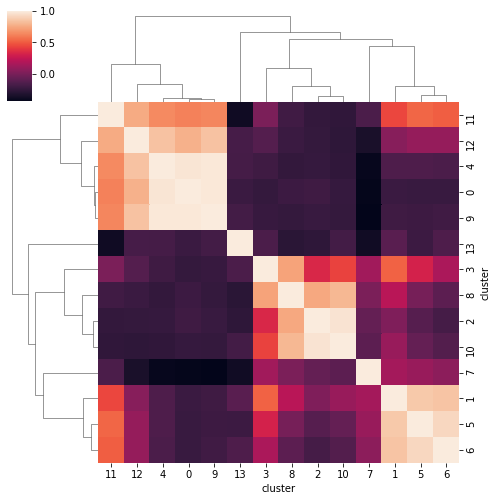

In [81]:
cg = sns.clustermap(marker_df.T.corr(), figsize=(7,7))

<AxesSubplot:ylabel='cluster'>

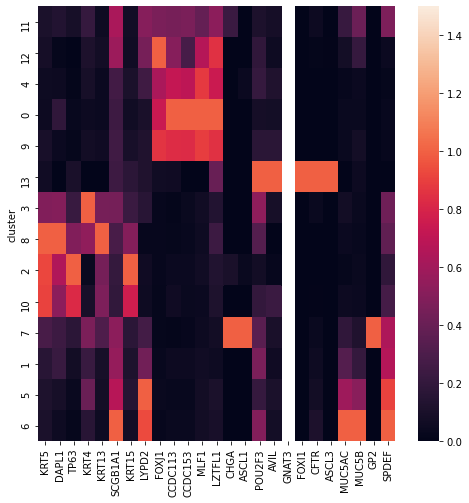

In [82]:
order = cg.dendrogram_row.reordered_ind
plt.figure(figsize=(8,8))
sns.heatmap(marker_df.iloc[order, :], vmax=1.5)

In [83]:
cell_type_converter = \
    ['basal' for i in range(8)] + \
    ['basal/club' for i in range(5)] + \
    ['goblet'] + \
    ['basal/club' for i in range(6)] + \
    ['ciliated' for i in range(7)] + \
    ['ionocyte/tuft'] + ['neuroendo']
cell_type_converter = dict(zip(order, cell_type_converter))

In [84]:
rna_adata.obs['cell_type'] = rna_adata.obs['leiden'].apply(lambda x: cell_type_converter[int(x)])

... storing 'cell_type' as categorical


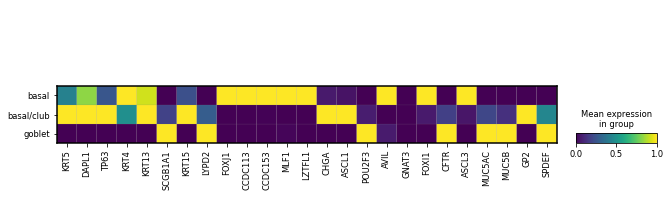

In [85]:
sc.pl.matrixplot(rna_adata, marker_genes, groupby='cell_type', standard_scale='var')

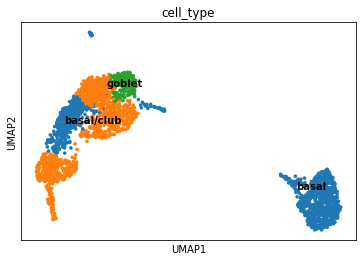

In [86]:
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data')

### Save the objects

In [62]:
rna_adata.write(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [63]:
rna_adata_counts.obs = rna_adata.obs
rna_adata_counts.write(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

### Make expression histograms

In [19]:
rna_adata_counts = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [20]:
sc.pp.normalize_total(rna_adata_counts, target_sum=1e4)

In [21]:
sc.pp.log1p(rna_adata_counts)

In [22]:
rna_adata_counts.obs['GBP1'] = rna_adata_counts[:, 'GBP1'].X.toarray()
rna_adata_counts.obs['STAT1'] = rna_adata_counts[:, 'STAT1'].X.toarray()

In [23]:
dat = rna_adata_counts.obs.query('(stim == "gamma" | stim == "control") & cell_type == "ciliated"')

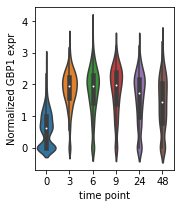

In [30]:
plt.figure(figsize=(2.5,3))
sns.violinplot(x='time', y='GBP1', data=dat)
plt.ylabel('Normalized GBP1 expr'); plt.xlabel('time point')
plt.savefig(fig_path + 'violin_GBP1.pdf', bbox_inches='tight')

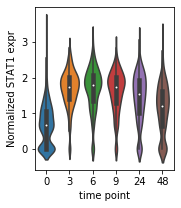

In [31]:
plt.figure(figsize=(2.5,3))
sns.violinplot(x='time', y='STAT1', data=dat);
plt.ylabel('Normalized STAT1 expr'); plt.xlabel('time point')
plt.savefig(fig_path + 'violin_STAT1.pdf', bbox_inches='tight')

### Make plots for figure

In [4]:
sc.set_figure_params(dpi=300)
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'
sc.settings.figdir = fig_path

In [5]:
rna_adata = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [6]:
rna_adata.shape

(69958, 3064)

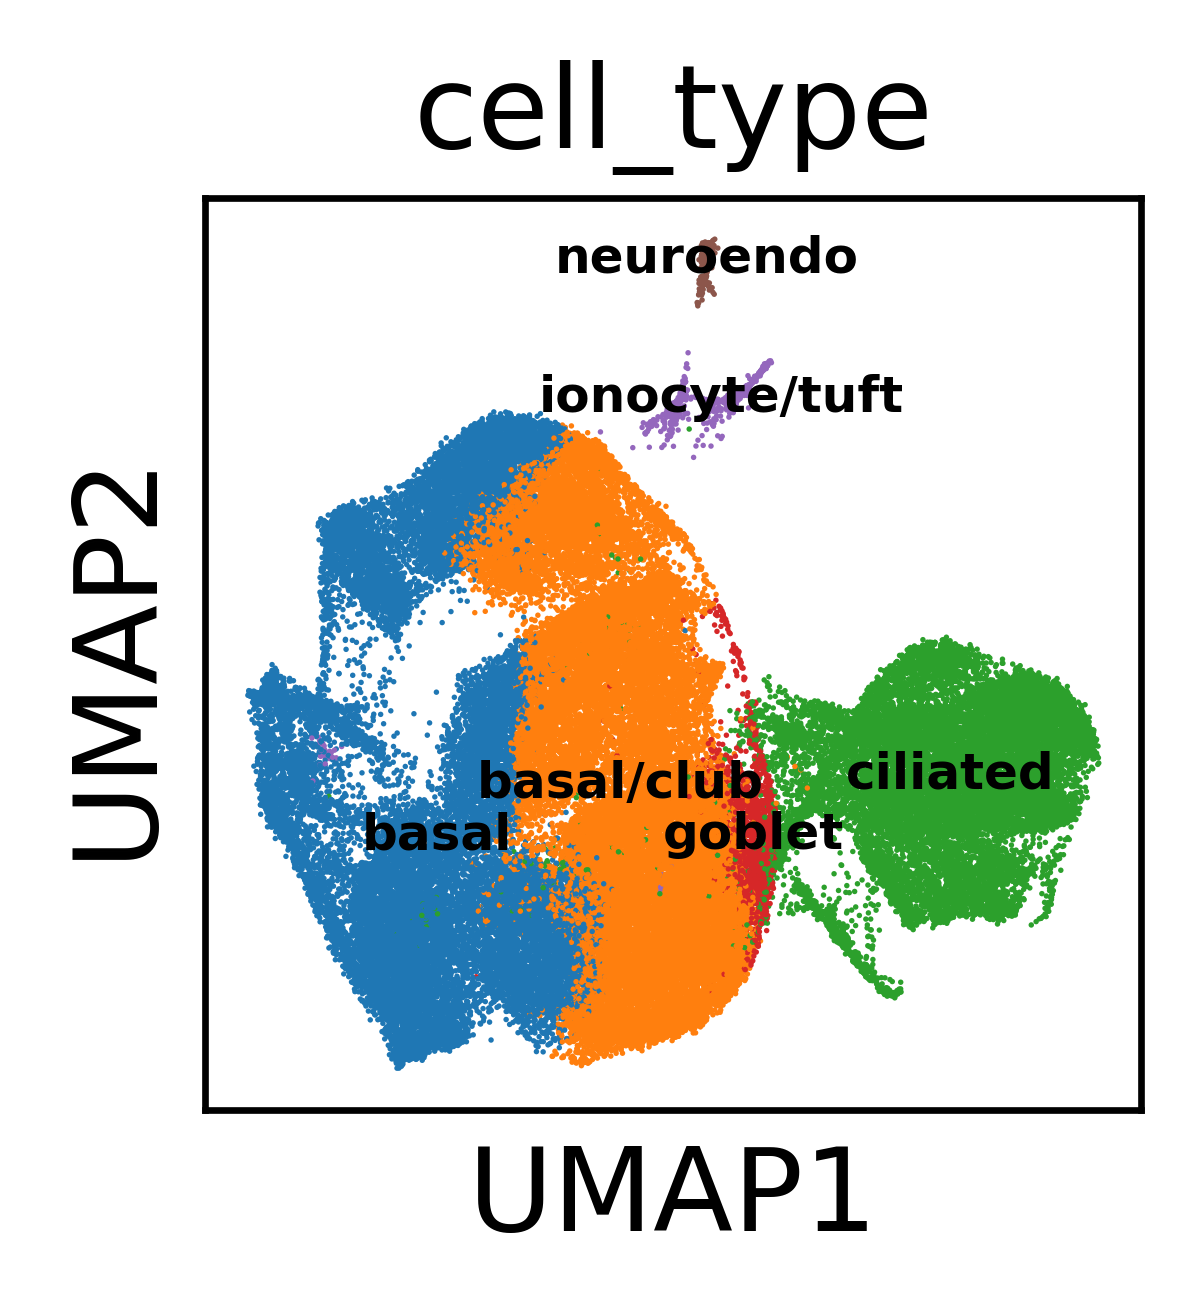

In [12]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(rna_adata, color='cell_type', legend_loc='on data', ax=ax, save='_ct.png', legend_fontsize=6);

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(rna_adata, color='stim', ax=ax, save='_stim.png')

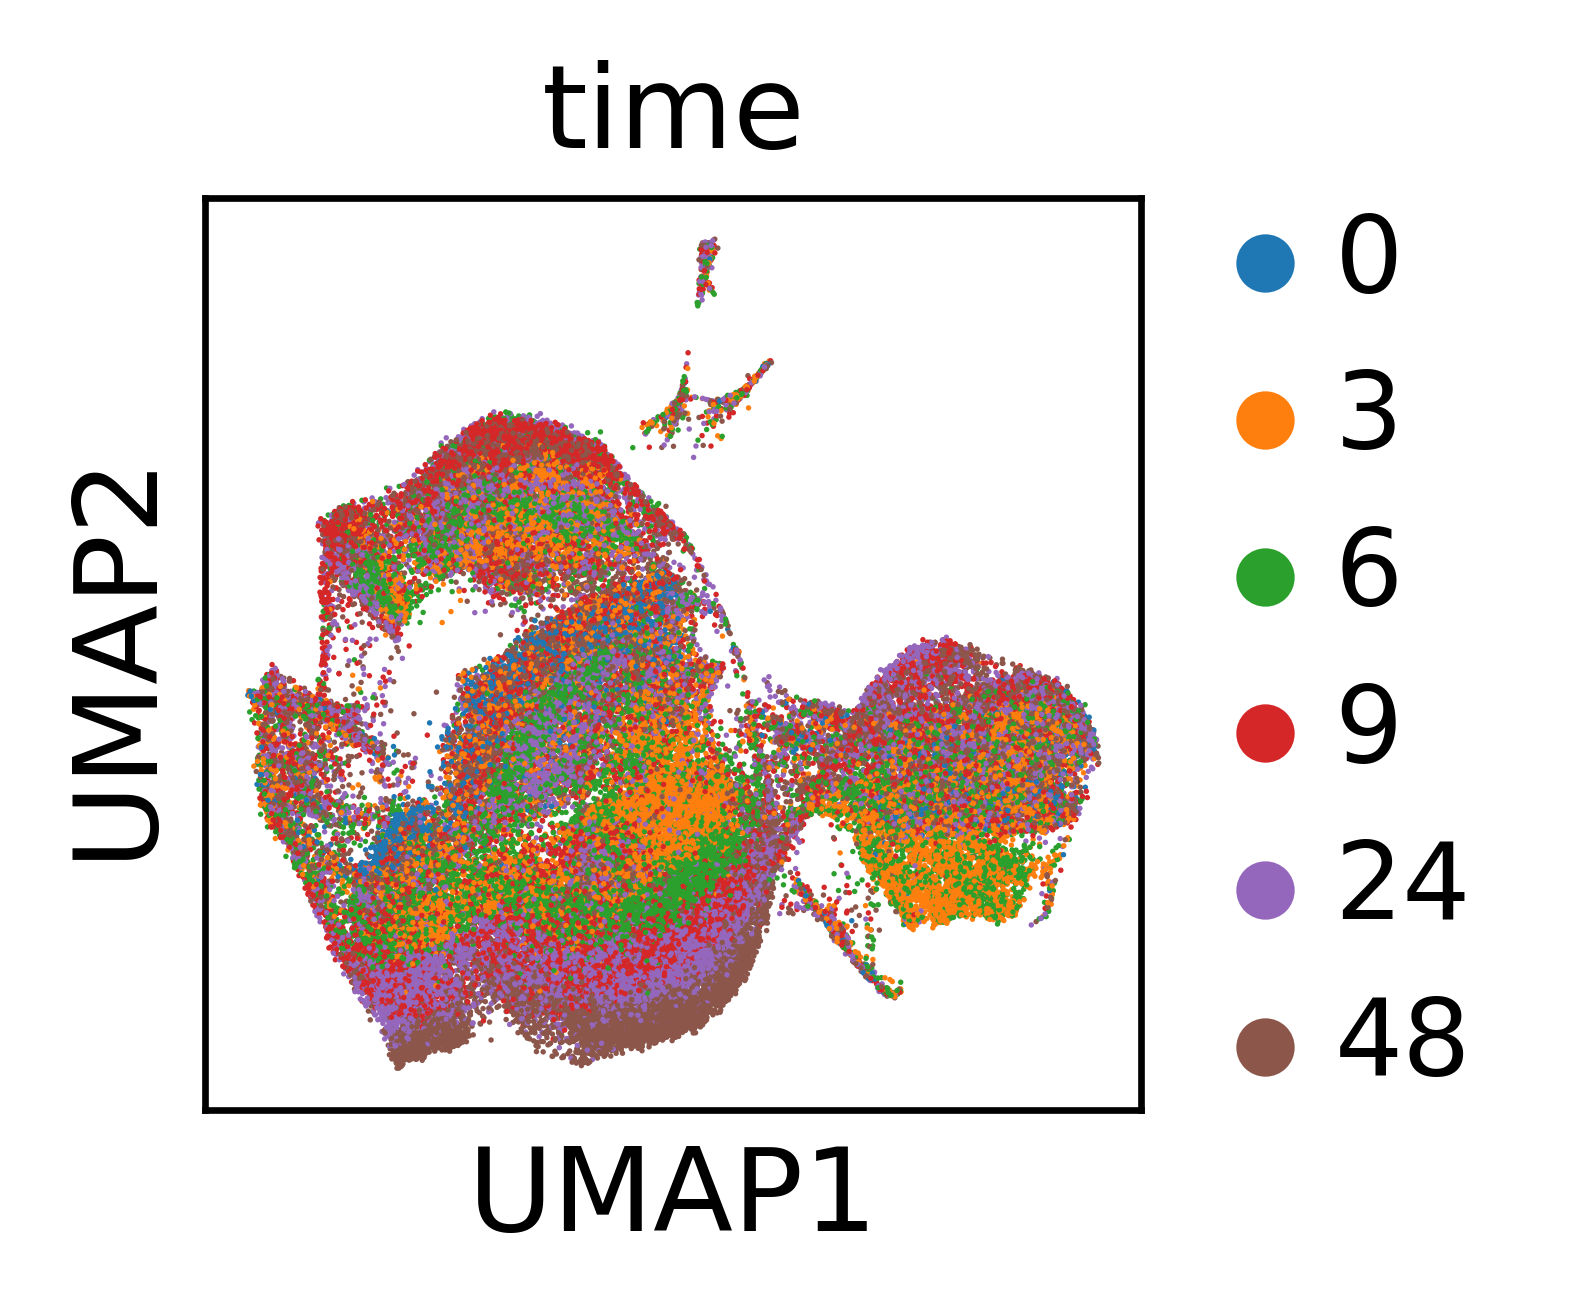

In [9]:
fig, ax = plt.subplots(figsize=(2,2))
sc.pl.umap(rna_adata, color='time', ax=ax, save='_time.png')

### Diagram figures

In [4]:
import scipy.stats as stats
import numpy as np

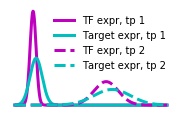

In [5]:
# Simple regulation
values = np.linspace(0, 25, 1000)
x1 = stats.norm.pdf(loc=3, scale=0.5, x=values)
y1 = stats.norm.pdf(loc=3.5, scale=1, x=values)

x2 = stats.norm.pdf(loc=15, scale=2, x=values)
y2 = stats.norm.pdf(loc=16, scale=3, x=values)

plt.figure(figsize=(3, 1.9))
plt.plot(values, x1, color='m', label='TF expr, tp 1', lw=3)
plt.plot(values, y1, color='c', label='Target expr, tp 1', lw=3)

plt.plot(values, x2, '--', color='m', label='TF expr, tp 2', lw=3)
plt.plot(values, y2, '--', color='c', label='Target expr, tp 2', lw=3)
plt.legend(frameon=False, fontsize='medium')
plt.axis('off')
plt.savefig(fig_path+'simple_diag.pdf', bbox_inches='tight')

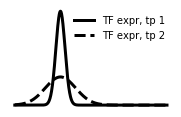

In [6]:
values = np.linspace(0, 10, 1000)

x1 = stats.norm.pdf(loc=3, scale=0.3, x=values)
x2 = stats.norm.pdf(loc=3, scale=1, x=values)
plt.figure(figsize=(3, 1.9))
plt.plot(values, x1, color='k', label='TF expr, tp 1', lw=3)
plt.plot(values, x2, '--',color='k', label='TF expr, tp 2', lw=3)
plt.legend(frameon=False, fontsize='medium')
plt.axis('off')

plt.savefig(fig_path+'pas_diag.pdf', bbox_inches='tight')